In [1]:
#importing the libraries
import pandas as pd
import numpy as np
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model,Sequential
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
#downloading data from google drive
!gdown --id 1n3uS9fjFurzVPLg1ncuqskBt6GPkTD5X
!unzip dog-breed-identification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/84

In [ ]:
#extracting the required data with breeds in the label_list
data = pd.read_csv('/content/labels.csv')
labels_list=['beagle','chihuahua','doberman','french_bulldog','golden_retriever','malamute','pug','saint_bernard','scottish_deerhound','tibetan_mastiff']
print("Types of dogs",len(labels_list))

data1 = data[data.breed.isin(labels_list)]
print('len of data: ',len(data1))


Types of dogs 10
len of data:  841


In [ ]:
data1.head()

,id,breed
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
20,008b1271ed1addaccf93783b39deab45,doberman
25,00a366d4b4a9bbb6c8a63126697b7656,golden_retriever
37,0100f55e4f0fe28f2c0465d3fc4b9897,golden_retriever


In [ ]:
# preprocessing the data
data1= data1.to_numpy()
x=[]
y=[]
for i in range(len(data1)):
  path = os.path.join('train',data1[i][0]+'.jpg')
  img = load_img(path,target_size=(224,224))
  img = img_to_array(img,data_format='channels_last')
  x.append(img)
  y.append(data1[i][1])

labelencoder=LabelEncoder()
y = labelencoder.fit_transform(y)
y = y.reshape(len(y),1)
y = OneHotEncoder(sparse=False).fit_transform(y)
x = np.array(x)
y = np.array(y)



In [ ]:
# the order of label encodings 
labelencoder.classes_

array(['beagle', 'chihuahua', 'doberman', 'french_bulldog',
       'golden_retriever', 'malamute', 'pug', 'saint_bernard',
       'scottish_deerhound', 'tibetan_mastiff'], dtype='<U18')

In [ ]:
#training data shape
x.shape

(841, 224, 224, 3)

In [ ]:
# training data result shape
y.shape

(841, 10)

In [2]:
#ResNet50 pretrained model from keras excluding the top layer 

basemodel = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3))

#marking the layers of resnet as non-trainable
basemodel.trainable = False  

94773248/94765736 [==============================] - 2s 0us/step


In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [3]:
# adding one pooling and two FCC layers 
model = Sequential(basemodel)
model.add(GlobalAveragePooling2D())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10,activation='softmax'))

adam = Adam(learning_rate=0.005)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# Summary of the model
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                2570      
Total params: 24,114,826
Trainable params: 527,114
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
#defining image data generator 
data_generator = ImageDataGenerator(horizontal_flip=True,rotation_range=20,validation_split=0.1)

train_gen = data_generator.flow(x,y,batch_size=32,shuffle=True,subset='training')
validation_gen = data_generator.flow(x,y,batch_size=32,shuffle=True,subset='validation')

In [ ]:
# defining some callbacks 
checkpoint = ModelCheckpoint('model_weights.h5',monitor='val_accuracy',save_best_only=True,save_weights_only=True,mode='max',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=2, min_lr=0.00001, mode='auto')
earlystopping = EarlyStopping(monitor='val_loss',mode='auto',patience=3)

callbacks = [checkpoint,reduce_lr, earlystopping]

#fitting the model
hist = model.fit(x=train_gen,epochs=15,validation_data=validation_gen,callbacks=callbacks)

Epoch 1/15
24/24 [==============================] - 150s 6s/step - loss: 4.0195 - accuracy: 0.4425 - val_loss: 0.6776 - val_accuracy: 0.7976

Epoch 00001: val_accuracy improved from -inf to 0.79762, saving model to model_weights.h5
Epoch 2/15
24/24 [==============================] - 140s 6s/step - loss: 0.7132 - accuracy: 0.7556 - val_loss: 0.4026 - val_accuracy: 0.8690

Epoch 00002: val_accuracy improved from 0.79762 to 0.86905, saving model to model_weights.h5
Epoch 3/15
24/24 [==============================] - 146s 6s/step - loss: 0.5660 - accuracy: 0.8058 - val_loss: 0.4523 - val_accuracy: 0.8452

Epoch 00003: val_accuracy did not improve from 0.86905
Epoch 4/15
24/24 [==============================] - 146s 6s/step - loss: 0.4160 - accuracy: 0.8560 - val_loss: 0.3442 - val_accuracy: 0.8810

Epoch 00004: val_accuracy improved from 0.86905 to 0.88095, saving model to model_weights.h5
Epoch 5/15
24/24 [==============================] - 145s 6s/step - loss: 0.3500 - accuracy: 0.8758 - 

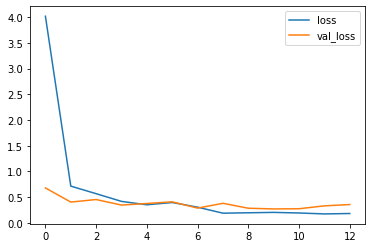

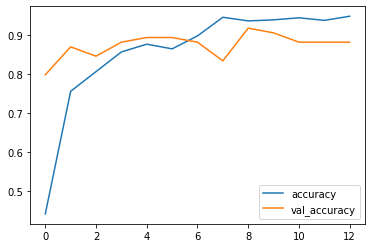

In [ ]:
# plotting the loss and accuracy with epochs
history_frame = pd.DataFrame(hist.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [ ]:
# saving the model architecture as json 
model_json = model.to_json()
with open('model.json','w') as file:
  file.write(model_json)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [6]:
# loading the saved model

!gdown --id 1UmUCIYHuXrxnAYBJqbFHGZmzUTaYGfDC
model.load_weights('model_weights.h5')

def preprocess_img(path):
  img = load_img(path,target_size=(224,224))
  img = img_to_array(img,data_format='channels_last')
  img=np.expand_dims(img,axis=0)
  return img

#prediction
def predict(path):
  labels=['beagle', 'chihuahua', 'doberman', 'french_bulldog',
       'golden_retriever', 'malamute', 'pug', 'saint_bernard',
       'scottish_deerhound', 'tibetan_mastiff']
  img = preprocess_img(path)
  pred=model.predict(img)
  result = np.hstack((np.reshape(np.array(labels),(10,1)),pred.T))
  
  if np.max(pred)>0.7:
    print('The dog is ',labels[np.argmax(pred)],' with confidence ',np.max(pred)*100,'%')
  else:
    print('Predicted:',result)
    print('\nThe dog does not match with anyone in the database ',labels)

Downloading...
From: https://drive.google.com/uc?id=1UmUCIYHuXrxnAYBJqbFHGZmzUTaYGfDC
To: /content/model_weights.h5
96.7MB [00:00, 126MB/s]


In [12]:
from PIL import Image

The dog is  doberman  with confidence  99.9771773815155 %


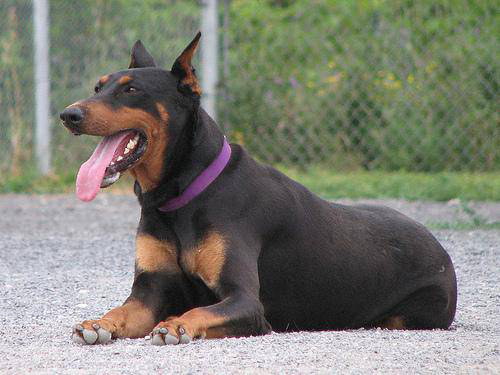

In [13]:
path='/content/008b1271ed1addaccf93783b39deab45.jpg'
predict(path)
Image.open(path)